# Disease Course Sequencing with the DEBM 
## pyEBM Walkthrough
### This page is a static html file. Click [here](https://colab.research.google.com/github/Disease-Progression-Modelling/disease-progression-modelling.github.io/blob/master/pages/notebooks/ebm/T2_pyEBM_walkthrough.ipynb) for online execution of the codes in this tutorial

![DEBM Illustration](debm_illu.jpg)


Text(0, 0.5, 'sigmoid(t)')

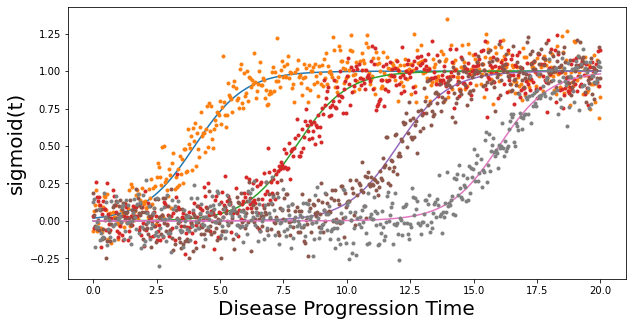

In [1]:
## Simulate data using sigmoids. Low values indicate healthy biomarkers. High values indicate abnormal biomarker values.
import numpy as np
from matplotlib import pyplot as plt 

def simulate_data(noise_scale,gradients,onsets):
    N = 4   # number of events/features
    J = 500 # number of patients
    dp = np.linspace(0, 20, J)
    def sigmoid(t,a=1,b=-10):
        return 1/(1 + np.exp(-a*(t-b)))

    X = np.empty(shape=(J,N))
    fig,ax = plt.subplots(figsize=(10,5))
    for a,b,k in zip(gradients,onsets,range(len(gradients))):
        # print('a = %i, b = %i' % (a,b))
        x = sigmoid(t=dp,a=a,b=b)
        #print(x)
        ax.plot(dp, x)
        y = x + np.random.normal(0, noise_scale, x.size)
        X[:,k] = y
        ax.plot(dp, y,'.')

    ax.set_xlabel("Disease Progression Time",fontsize=20) 
    ax.set_ylabel("sigmoid(t)",fontsize=20)

    return X, dp

noise_scale = 0.1
gradients = np.array([1,1,1,1])
onsets    = np.array([4,8,12,16])

X, dp = simulate_data(noise_scale,gradients,onsets)

In [2]:
## define cases, controls, and subjects in the prodromal stage of disease
## For example: if the cases represent Alzheimer's disease (AD), mild cognitive impairment (MCI) is the prodromal stage of the disease

## dp is the simulated disease timeline (x-axis of the above plot). This function sets 2 thresholds on the disease timeline to define 3 diagnostic classes in the simulated data.
import pandas as pd 

## Prepare data for DEBM call.

def prepare_data(X, dp, thresh1, thresh2):
    idx_cases = dp >= thresh2
    idx_controls = dp <= thresh1
    idx_mci  = np.logical_and(dp>thresh1,dp<thresh2)
    D = pd.DataFrame()
    # This sets the order in which different biomarkers become abnormal
    # The set order is biomarker 3 -> followed by 1 --> followed by 4 --> followed by 2
    D['Biomarker 3'] = X[:,0]
    D['Biomarker 1'] = X[:,1]
    D['Biomarker 4'] = X[:,2]
    D['Biomarker 2'] = X[:,3]

    D['Diagnosis'] = ''
    D.loc[idx_cases,'Diagnosis'] = 'AD'
    D.loc[idx_controls,'Diagnosis'] = 'CN'
    D.loc[idx_mci,'Diagnosis'] = 'MCI'
    D['PTID']=D.index
    return D

D = prepare_data(X, dp, 7, 14)

In [6]:
!pip install pyebm
from pyebm import debm

## Basic call
ModelOutput, SubjTrain, _  = debm.fit(D,Factors=[],Labels=['CN','MCI','AD'])
print([ModelOutput.BiomarkerList[x] for x in ModelOutput.MeanCentralOrdering])

## Note: The order printed here is the same as the ground truth ordering set obove. You can verify this by changing the order in which biomarkers becomes abnormal in the above cell.

['Biomarker 3', 'Biomarker 1', 'Biomarker 4', 'Biomarker 2']


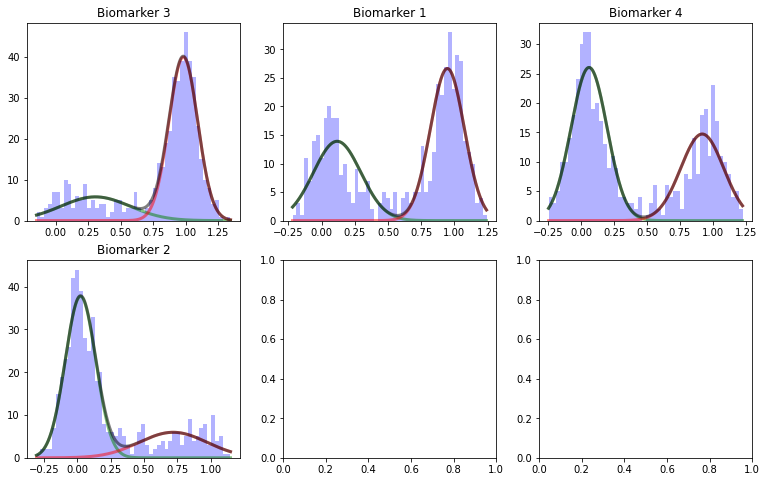

In [7]:
## If you want to view the outputs of the model in different stages you can use VerboseOptions
# In this example, you can view the output of Gaussian Mixture Model
from collections import namedtuple 
VO = namedtuple('VerboseOptions','Distributions')
VO.Distributions = 1
ModelOutput, SubjTrain, _  = debm.fit(D,Factors=[],Labels=['CN','MCI','AD'], VerboseOptions=VO)

[0][1][2][3][4][5][6][7][8][9]

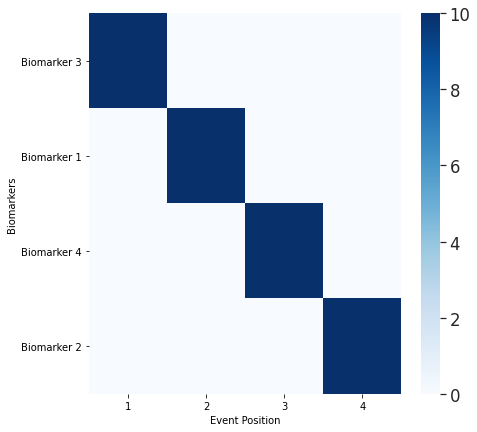

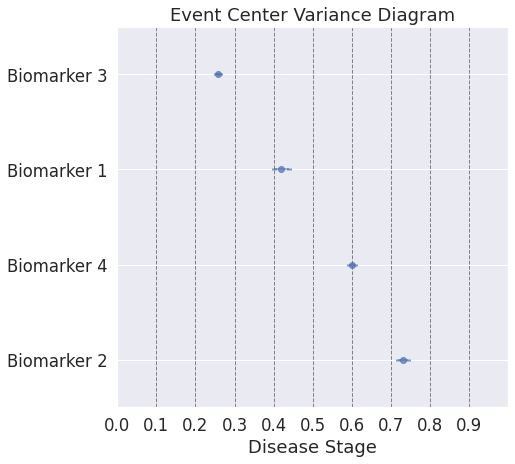

In [8]:
## Uncertainty estimates of the model can be computed by bootstrap resampling the input data. This can be controlled by MethodOptions

# Bootstrapping
MO = namedtuple('MethodOptions','Bootstrap')
MO.Bootstrap = 10 # Indicates 10 random iterations of bootstrap resampling

# Visual output of the ordering can be obtained by:
VO = namedtuple('VerboseOptions','Ordering')
VO.Ordering = 1
ModelOutput, SubjTrain, _  = debm.fit(D,Factors=[],Labels=['CN','MCI','AD'], VerboseOptions=VO, MethodOptions=MO)

## Note: On top of estimating the sequence in which biomarkers become abnormal, the method also estimates the relative temporal distance between the different biomarkers

Text(0, 0.5, 'sigmoid(t)')

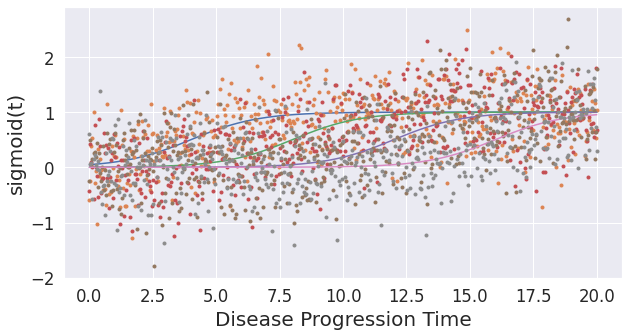

In [9]:
## The model estimates are very certain because the simulated data is near perfect. Real data usually has measurement errors, low effect sizes etc. Here, you can simulate a more difficult data using noise_scale parameter and the gradients parameters (lower value indicates slower progressing biomarkers, which results in lower effect sizes).

noise_scale = 0.5 # Increased this from 0.1
gradients = np.array([0.75,0.75,0.75,0.75])
onsets    = np.array([4,8,12,16])

X, dp = simulate_data(noise_scale,gradients,onsets)

In [10]:
## define cases, controls, and subjects in the prodromal stage of disease
## For example: if the cases represent Alzheimer's disease (AD), mild cognitive impairment (MCI) is the prodromal stage of the disease

## dp is the simulated disease timeline (x-axis of the above plot). This function sets 2 thresholds on the disease timeline to define 3 diagnostic classes in the simulated data.
D = prepare_data(X, dp, 7, 14)

[0][1][2][3][4][5][6][7][8][9]

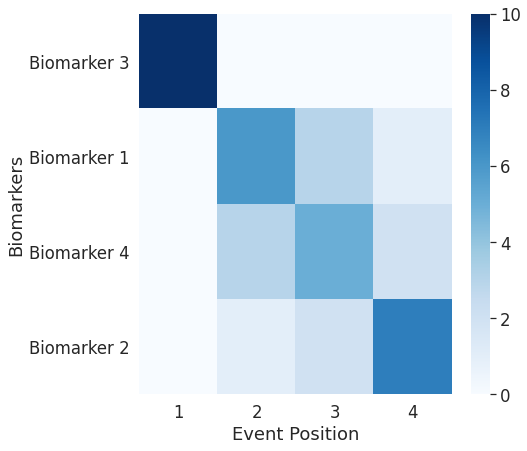

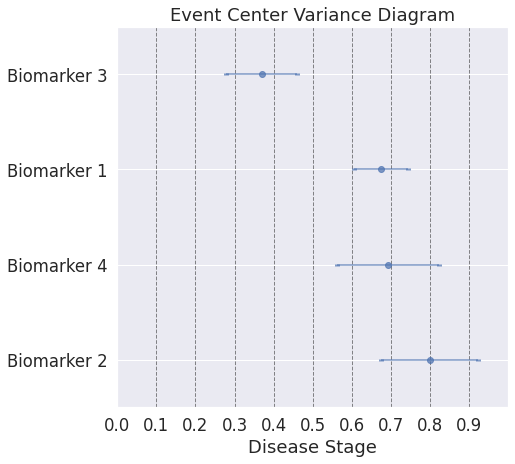

In [11]:
# Bootstrapping
MO = namedtuple('MethodOptions','Bootstrap')
MO.Bootstrap = 10 # Indicates 10 random iterations of bootstrap resampling

# Visual output of the ordering can be obtained by:
VO = namedtuple('VerboseOptions','Ordering')
VO.Ordering = 1
ModelOutput, SubjTrain, _  = debm.fit(D,Factors=[],Labels=['CN','MCI','AD'], VerboseOptions=VO, MethodOptions=MO)

## Note: With a more difficult simulated dataset, the uncertainties of the estimates can be more easily seen.

Text(0, 0.5, 'sigmoid(t)')

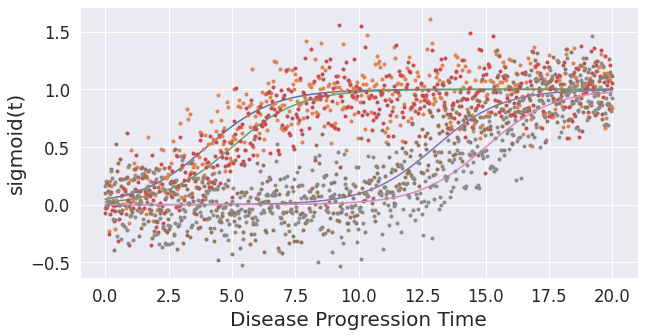

In [12]:
## In real data, the sequence of biomarkers in itself is not fully informative, because some biomarkers become abnormal at almost the same time, whereas some others become abnormal at substantially different times. In the simulated data this can be controlled by the variable "onsets". 

noise_scale = 0.2
gradients = np.array([0.75,0.75,0.75,0.75])
onsets    = np.array([4,5,13,15]) # earlier value [4,8,12,16]

X, dp = simulate_data(noise_scale,gradients,onsets)

In [13]:
## define cases, controls, and subjects in the prodromal stage of disease
## For example: if the cases represent Alzheimer's disease (AD), mild cognitive impairment (MCI) is the prodromal stage of the disease

## dp is the simulated disease timeline (x-axis of the above plot)
D = prepare_data(X, dp, 7, 14)

[0][1][2][3][4][5][6][7][8][9]

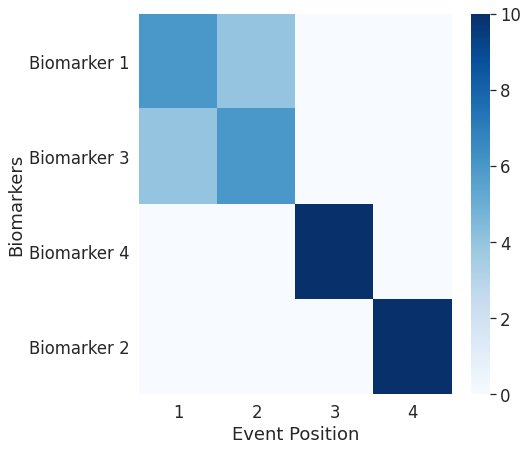

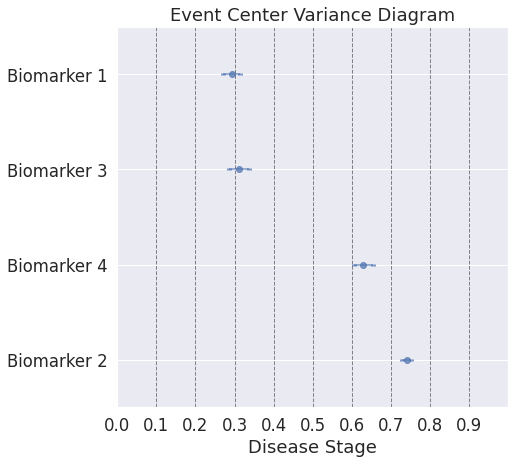

In [14]:
# Bootstrapping
MO = namedtuple('MethodOptions','Bootstrap')
MO.Bootstrap = 10 # Indicates 10 random iterations of bootstrap resampling

# Visual output of the ordering can be obtained by:
VO = namedtuple('VerboseOptions','Ordering')
VO.Ordering = 1
ModelOutput, SubjTrain, _  = debm.fit(D,Factors=[],Labels=['CN','MCI','AD'], VerboseOptions=VO, MethodOptions=MO)

## Note: Here, even though the ordering plot shows a similar ordering as the first dataset, the event-center plot shows how close the biomarker abnormality events are to each other.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Estimated patient stages of subjects in training set


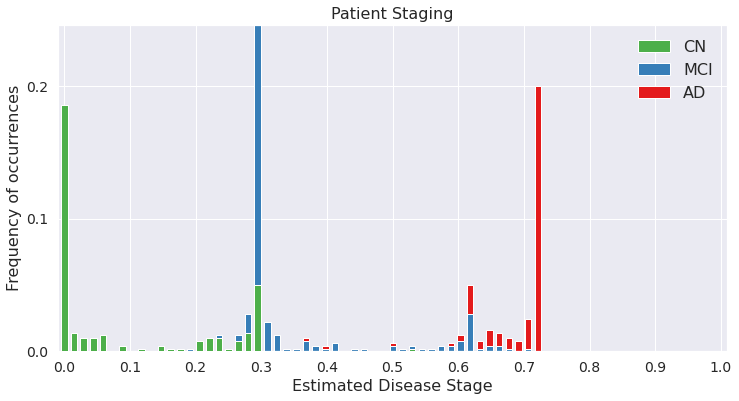

In [15]:
## The outputs until now were for the entire datasets. Now we will look into patient specific outputs
## Patient Staging estimates the stages of different subjects along the disease timeline. 
MO = namedtuple('MethodOptions','Bootstrap')
MO.Bootstrap = 0 
VO = namedtuple('VerboseOptions','PatientStaging')
VO.PatientStaging = 1
ModelOutput, SubjTrain, _  = debm.fit(D,Factors=[],Labels=['CN','MCI','AD'], VerboseOptions=VO, MethodOptions=MO)

## Note: Unlike EBM, DEBM estimates patient stages between 0 and 1 (rather between 0 and the position of the last event-center), since it also considers relative positioning of events into account.

Estimated patient stages of subjects in training set


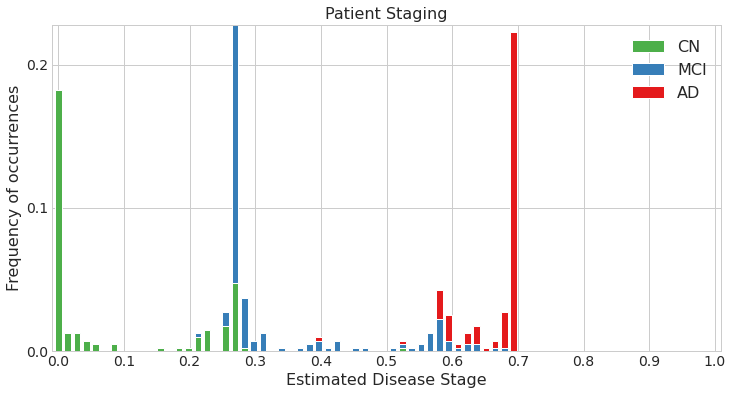

Estimated patient stages of subjects in test set


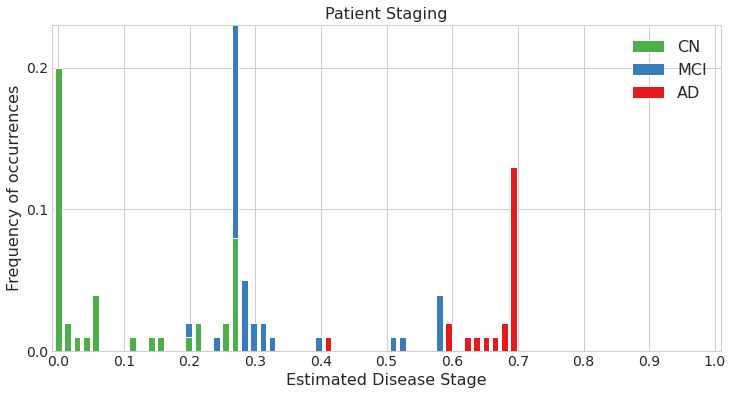

In [16]:
## All the computations until now were done on the training set. If you have a separate test / validation set, that can be included as input in the function call as well.
from sklearn import model_selection

DTrain, DTest = model_selection.train_test_split(D,test_size=0.2)

MO = namedtuple('MethodOptions','Bootstrap')
MO.Bootstrap = 0 
VO = namedtuple('VerboseOptions','PatientStaging')
VO.PatientStaging = 1
ModelOutput, SubjTrain, _  = debm.fit(DTrain,Factors=[],Labels=['CN','MCI','AD'], VerboseOptions=VO, MethodOptions=MO, DataTest=DTest)

In [17]:
## In the simulated datasets, we could compare the estimated ordering to the ground-truth ordering to see how accurate our estimate was. This is not possible in real data. One of the ways for validating the model in real data is by using the accuracy of classification of patients into different diagnostic groups (for e.g. CN vs AD) using the DEBM model's patient stages.

## Here, we compute the AUC for CN vs AD classification, done in a cross-validated manner

from sklearn.model_selection import StratifiedKFold as SKF
from sklearn import metrics

MO = namedtuple('MethodOptions', 'Bootstrap')
MO.Bootstrap = 0;

VO = namedtuple('VerboseOptions', 'Distributions PatientStaging')
VO.PatientStaging = 0;
VO.Distributions = 0;

Y = D['Diagnosis'].copy();
Y[Y == 'CN'] = 0;
Y[Y == 'AD'] = 2;
Y[Y == 'MCI'] = 1;

skf = SKF(n_splits=10, shuffle=True, random_state=42)
print("Cross-Validation Iteration:")
stages = np.zeros(D.shape[0])+np.nan
count = -1
for train_index, test_index in skf.split(D, pd.to_numeric(Y.values)):
    count = count + 1;
    print([count],end=",",flush=True)
    DTrain, DTest = D.iloc[train_index], D.iloc[test_index]
    ModelOutput, SubjTrain, SubjTest = debm.fit(DTrain, Factors=[], Labels=['CN','MCI','AD'],MethodOptions=MO, VerboseOptions=VO, DataTest=DTest)

    stages[test_index] = SubjTest[0]['Stages'].values

Yt = D['Diagnosis']
idx = Yt != 'MCI'
Yt = Yt[idx]
Yt[Yt == 'CN'] = 0
Yt[Yt == 'AD'] = 1

auc = metrics.roc_auc_score(pd.to_numeric(Yt.values), stages[idx])

print("\AUC of DEBM using 10-fold cross-validation = ", auc)

## Note: The AUC is very high because the simulated dataset is near ideal. You can try to change the following parameters in the simulation script and see how the auc gets affected: noise_scale, gradients, onsets

Cross-Validation Iteration:
[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],\AUC of DEBM using 10-fold cross-validation =  0.9998857142857144
